# Cargar y preprocesar imágenes

In [17]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

IMAGE_SIZE = 180
BATCH_SIZE = 32
CHANNELS = 3 # todavia no se que es esto
EPOCHS = 50 # ya se vera cual es el numero correcto // habia que hacer un rico for para ver que numero es

## Separamos las fotos en imagenes de entrenamiento (80%) y validación (20%) 

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Aves seleccionadas",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
   "Aves seleccionadas",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1700 files belonging to 8 classes.
Using 1360 files for training.
Found 1700 files belonging to 8 classes.
Using 340 files for validation.


In [3]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['Alcedo atthis',
 'Alopochen aegyptiaca',
 'Branta canadensis',
 'Ciconia ciconia',
 'Fulica atra',
 'Himantopus himantopus',
 'Myiopsitta monachus',
 'Psittacula krameri']

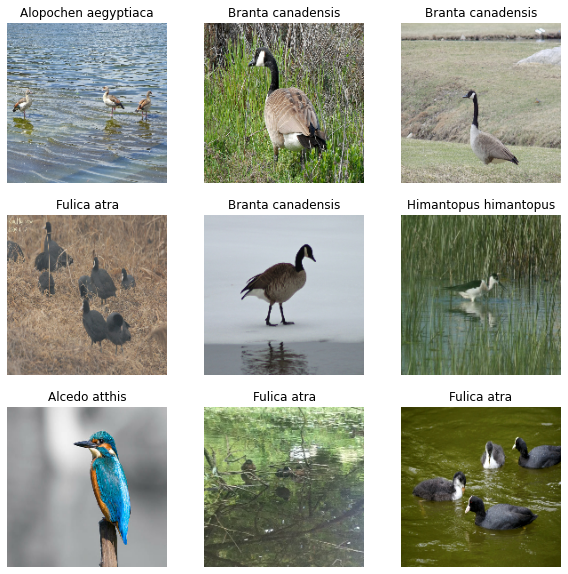

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [111]:
# poner graficos pie chart

## Configurar el conjunto de datos para el rendimiento

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Estandarización de datos
#### Actualmente las fotos estan en el rango RGB de [0, 255]. Esto no es ideal para una red neuronal, por eso hay que buscar que los valores de entrada sean mas pequeños

In [6]:
rescale_and_resize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

## Aumento de datos
#### El aumento de datos se hace cuando no se tiene muchos datos, ademas ayuda a corregir el overfitting

In [7]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

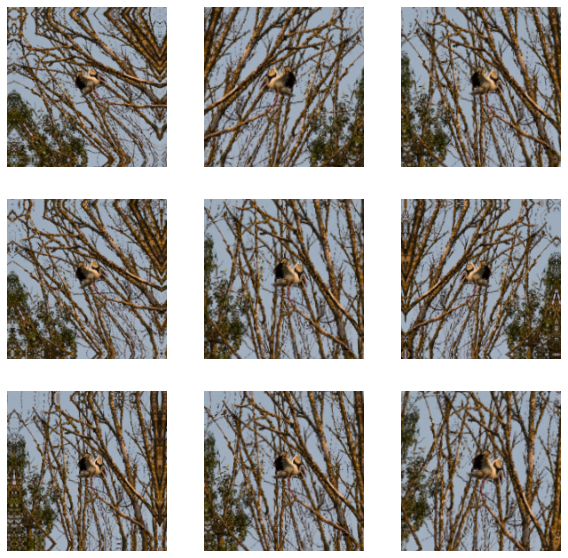

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Creación del modelo CNN

In [9]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.Sequential([
    rescale_and_resize,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.5), # ayuda a corregir el overfitting lo de quitar algunas redes neuronales
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

# model = tf.keras.Sequential([
#     rescale_and_resize,
#     data_augmentation,

#     layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.MaxPooling2D(),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax'),
#     layers.Dropout(0.5),
# ])

model.build(input_shape=input_shape)

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 module_wrapper (ModuleWrapp  (32, 180, 180, 16)       448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (32, 90, 90, 16)         0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (32, 90, 90, 32)         4640      
 pper)                                                           
                                                      

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True) # que si ha mejorado el modelo lo guarde
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks=[early_stopping]

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
43/43 [==============================] - 23s 507ms/step - loss: 2.0630 - accuracy: 0.1816 - val_loss: 1.9503 - val_accuracy: 0.2647
Epoch 2/50
43/43 [==============================] - 23s 547ms/step - loss: 1.9484 - accuracy: 0.2456 - val_loss: 1.8420 - val_accuracy: 0.3029
Epoch 3/50
43/43 [==============================] - 24s 550ms/step - loss: 1.8657 - accuracy: 0.2868 - val_loss: 1.8868 - val_accuracy: 0.3118
Epoch 4/50
43/43 [==============================] - 23s 538ms/step - loss: 1.7787 - accuracy: 0.3176 - val_loss: 1.7935 - val_accuracy: 0.3059
Epoch 5/50
43/43 [==============================] - 23s 524ms/step - loss: 1.6955 - accuracy: 0.3500 - val_loss: 1.8575 - val_accuracy: 0.3000
Epoch 6/50
43/43 [==============================] - 23s 528ms/step - loss: 1.6274 - accuracy: 0.3956 - val_loss: 1.7420 - val_accuracy: 0.3441
Epoch 7/50
43/43 [==============================] - 23s 546ms/step - loss: 1.5403 - accuracy: 0.4368 - val_loss: 1.5474 - val_accuracy: 0.4588

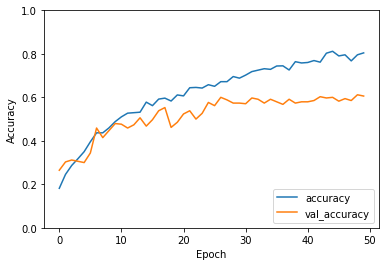

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

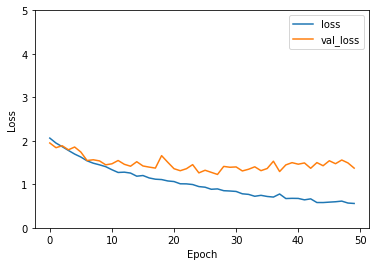

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')

In [1]:
img = tf.keras.utils.load_img(
    'C:/Users/aritz/OneDrive/Escritorio/unknown.png', target_size=(IMAGE_SIZE, IMAGE_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

score*100


NameError: name 'tf' is not defined

In [48]:
import glob

result = []

for filename in glob.glob('C:/Users/aritz/OneDrive/Escritorio/MUUUH/3. maila/2/PBL/Descarte de fotos/Branta canadensis/*.jpg'):
    img = tf.keras.utils.load_img(
     filename, target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    result.append(class_names[np.argmax(score)])

print(result.count('Branta canadensis'))
result.count('Fulica atra')
result.count('Himantopus himantopus')
result.count('Ciconia ciconia')
result.count('Alcedo atthis')
result.count('Alopochen aegyptiaca')

366

In [49]:
print(result.count('Branta canadensis'))
print(result.count('Fulica atra'))
print(result.count('Himantopus himantopus'))
print(result.count('Ciconia ciconia'))
print(result.count('Alcedo atthis'))
print(result.count('Alopochen aegyptiaca'))

542
143
112
116
61
366
